In [22]:
# Установка необходимых библиотек (раскомментируйте при необходимости)
# !pip install tensorflow tensorflow-hub opencv-python matplotlib

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import time

import urllib.request
import os

from google.colab.patches import cv2_imshow
from IPython.display import clear_output

In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = '/GPU:0'
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        print(f"Устройство выбрано: GPU ({gpu_details.get('device_name', 'Unknown GPU')})")
        print(f"ID устройства: {device_name}")
    except:
        print(f"Устройство выбрано: GPU {device_name}")
else:
    device_name = '/CPU:0'
    print("GPU не найден. Вычисления будут идти на CPU (это может быть медленно).")

Устройство выбрано: GPU (Tesla T4)
ID устройства: /GPU:0


In [24]:
def extract_frames(video_path, output_folder, frame_interval=10):
    """
    Извлекает кадры из видео с заданным интервалом.
    Основано на требованиях к подготовке данных[cite: 138].
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Ошибка открытия видео: {video_path}")
        return

    frame_count = 0
    saved_count = 0

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Video FPS: {fps}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Сохраняем каждый N-й кадр [cite: 138]
        if frame_count % frame_interval == 0:
            filename = os.path.join(output_folder, f"frame_{saved_count}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Извлечено {saved_count} фреймов в папку {output_folder}")

In [25]:
def download_sample_video():
    # Ссылка на тестовое видео (люди, велосипеды, машины)
    # Источник: Intel IoT DevKit Sample Videos
    video_url = "https://github.com/intel-iot-devkit/sample-videos/raw/master/person-bicycle-car-detection.mp4"
    filename = "test_video.mp4"

    if not os.path.exists(filename):
        print(f"Скачивание видео {filename}...")
        try:
            urllib.request.urlretrieve(video_url, filename)
            print("✅ Видео успешно скачано!")
        except Exception as e:
            print(f"❌ Ошибка при скачивании: {e}")
    else:
        print(f"ℹ️ Файл {filename} уже существует.")

    return filename

In [26]:
# Скачиваем видео
video_path = download_sample_video()
print(f"Путь к видеофайлу: {video_path}")

ℹ️ Файл test_video.mp4 уже существует.
Путь к видеофайлу: test_video.mp4


In [27]:
extract_frames(video_path, 'dataset/frames', frame_interval=10)

Video FPS: 12
Извлечено 65 фреймов в папку dataset/frames


In [28]:
def load_detection_model():
    """
    Загружает предобученную модель Faster R-CNN Inception ResNet V2.
    Ссылка на модель соответствует рекомендациям задания[cite: 179].
    """
    print("Загрузка модели с TF Hub...")
    # Используем модель Faster R-CNN, обученную на COCO 2017
    module_handle = "https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1"
    detector = hub.load(module_handle)
    print("Модель загружена.")
    return detector

In [29]:
detector = load_detection_model()

Загрузка модели с TF Hub...
Модель загружена.


In [30]:
def draw_boxes(image, boxes, class_ids, scores, threshold=0.5):
    """
    Визуализация bounding box'ов на изображении[cite: 85, 275].
    Отображает класс и уверенность (confidence).
    """
    image_h, image_w, _ = image.shape
    output_image = image.copy()

    for i in range(len(boxes)):
        if scores[i] >= threshold:
            # Координаты бокса: [ymin, xmin, ymax, xmax]
            ymin, xmin, ymax, xmax = boxes[i]

            # Преобразование в пиксели
            (left, right, top, bottom) = (xmin * image_w, xmax * image_w,
                                          ymin * image_h, ymax * image_h)

            # Рисуем прямоугольник
            cv2.rectangle(output_image, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)

            # Добавляем подпись (класс + уверенность) [cite: 16]
            label = f"Class: {int(class_ids[i])}, Conf: {scores[i]:.2f}"
            cv2.putText(output_image, label, (int(left), int(top)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return output_image

In [31]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import cv2
import time
import tensorflow as tf

def process_video_stream(video_path, output_path=None, confidence_threshold=0.5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Ошибка открытия файла: {video_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Настройка записи видео (если нужно сохранить результат)
    out = None
    if output_path:
        # В Colab лучше использовать кодек 'mp4v' или 'H264' (через 'avc1')
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, 20.0, (width, height))

    frame_count = 0
    start_time = time.time()

    print("Начало обработки...")

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Визуализация каждого кадра в браузере очень медленная.
            # Для теста будем показывать только каждый 5-й кадр,
            # но обрабатывать и сохранять будем всё равно.
            show_frame = (frame_count % 5 == 0)

            # Подготовка тензора
            input_tensor = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_tensor = tf.convert_to_tensor(input_tensor)
            input_tensor = input_tensor[tf.newaxis, ...]

            # Инференс (на GPU это будет быстро)
            result = detector(input_tensor)

            boxes = result['detection_boxes'][0].numpy()
            scores = result['detection_scores'][0].numpy()
            class_ids = result['detection_classes'][0].numpy()

            # Рисуем боксы
            frame_with_boxes = draw_boxes(frame, boxes, class_ids, scores, threshold=confidence_threshold)

            # Расчет FPS
            curr_time = time.time()
            fps_curr = 1 / (curr_time - start_time) if (curr_time - start_time) > 0 else 0
            start_time = curr_time

            # Добавляем текст FPS
            cv2.putText(frame_with_boxes, f"FPS: {fps_curr:.2f}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # Сохранение в файл
            if out:
                out.write(frame_with_boxes)

            # --- ВИЗУАЛИЗАЦИЯ В COLAB ---
            if show_frame:
                clear_output(wait=True) # Очищаем предыдущий кадр
                cv2_imshow(frame_with_boxes) # Показываем новый (патч для Colab)
                # В Colab cv2.waitKey не работает для перехвата клавиш,
                # поэтому остановить можно только кнопкой "Stop" в ячейке

            frame_count += 1

            # Ограничитель для теста (чтобы не ждать обработки всего длинного видео)
            # Если хотите обработать всё видео - закомментируйте эти строки
            if frame_count > 100:
                print("Тестовый прогон: остановка на 100 кадрах.")
                break

    except KeyboardInterrupt:
        print("Обработка прервана пользователем")

    cap.release()
    if out:
        out.release()
        print(f"Результат сохранен в: {output_path}")

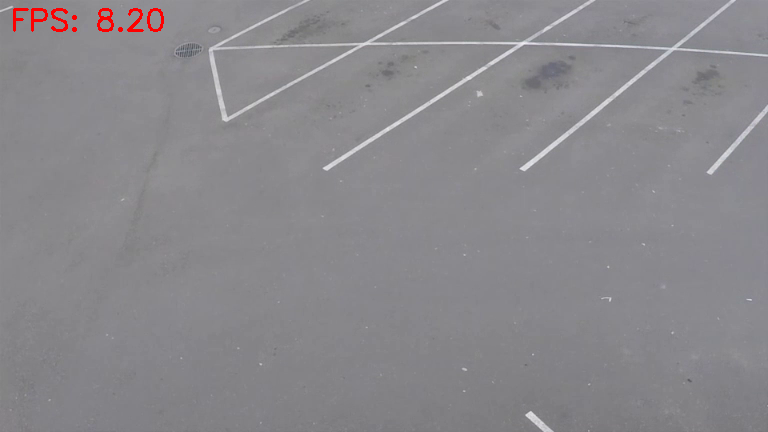

Тестовый прогон: остановка на 100 кадрах.
Результат сохранен в: output_result.mp4


In [21]:
process_video_stream(video_path, 'output_result.mp4')